In [1]:
!pip install swig
!pip install gymnasium[box2d]
!pip install renderlab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 15.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376170 sha256=6e0b784fcb416541bf8003deb0018bd6dc48de9de7ac7dee01c9730602f3c601
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [2]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt
from typing import Sequence
from collections import namedtuple, deque
import itertools
import random
import copy
from itertools import count, chain
from torch.distributions import Normal
import warnings
import renderlab as rl
warnings.filterwarnings("ignore")

In [3]:
env = gym.make("LunarLanderContinuous-v2", render_mode = "rgb_array")
obs = env.reset()
episode_reward = 0.0

In [4]:
GAMMA = 0.99
BATCH_SIZE = 64
BUFFER_SIZE = 10000
MIN_REPLAY_SIZE = 5000
TAU = 0.01
POLICY_NOISE = 0.2
NOISE_CLIP = 0.5
EXPL_NOISE = 0.1
POLICY_FREQ = 2
ALPHA = 0.02

## Soft Actor Critic (SAC)

In [5]:
T = lambda x: torch.as_tensor(x, dtype=torch.float32)
Ti = lambda x: torch.as_tensor(x, dtype=torch.int64)

In [6]:
# Policy/Actor Network
class PolicyNet(nn.Module):

    def __init__(self, input_size, hidden_units, output_size, pmin, pmax):
        super(PolicyNet, self).__init__()
        self.pmin = pmin
        self.pmax = pmax
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, int(hidden_units/2)),
            nn.Tanh()
        )
        self.mu_head = nn.Linear(int(hidden_units/2),  output_size)
        self.logstd_head = nn.Linear(int(hidden_units/2),  output_size)

    def forward(self, x):
        x = self.model(x)
        loc = torch.tanh(self.mu_head(x)) * self.pmax
        scale = torch.exp(self.logstd_head(x))

        dist = Normal(loc, scale)
        action = dist.rsample()
        log_prob = dist.log_prob(action)
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        log_prob -= (2* (np.log(2) - action - F.softplus(-2*action))).sum(dim=-1, keepdim=True)

        action = torch.tanh(action) * self.pmax

        return action, log_prob

    def __call__(self, x):
        out = self.forward(x)
        return out

In [7]:
#Critic Network
class DQN(nn.Module):

    def __init__(self, input_size, hidden_units):
        super(DQN, self).__init__()
        self.Q = nn.Sequential(
            nn.Linear(input_size, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, int(hidden_units/2)),
            nn.ReLU(),
            nn.Linear(int(hidden_units/2), 1)
        )

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        q = self.Q(x)
        return q

    def __call__(self, state, action):
        out = self.forward(state, action)
        return out

In [8]:
Transition = namedtuple('Transition', ('states', 'actions', 'rewards', 'dones', 'next_states'))

class Replay_memory():

    def __init__(self, env, fullsize, minsize, batchsize):
        self.env = env
        self.memory = deque(maxlen=fullsize)
        self.rewards = deque(maxlen=50)
        self.batchsize = batchsize
        self.minsize = minsize

    def append(self, transition):
        self.memory.append(transition)

    def sample_batch(self):
        batch = random.sample(self.memory, self.batchsize)
        batch = Transition(*zip(*batch))
        states = torch.from_numpy(np.array(batch.states, dtype=np.float32))
        actions = torch.from_numpy(np.array(batch.actions, dtype=np.float32))
        rewards = torch.from_numpy(np.array(batch.rewards, dtype=np.float32)).unsqueeze(1)
        dones = torch.from_numpy(np.array(batch.dones, dtype=np.bool8)).unsqueeze(1)
        next_states = torch.from_numpy(np.array(batch.next_states, dtype=np.float32))
        return states, actions, rewards, dones, next_states

    def initialize(self):
        obs, _ = env.reset()
        for _ in range(self.minsize):
            action = self.env.action_space.sample()
            new_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            transition = Transition(obs, action, reward, done, new_obs)
            self.append(transition)
            obs = new_obs
            if done:
                self.env.reset()
        return self

In [9]:
replay_memory = Replay_memory(env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE).initialize()

In [10]:
obs_size = env.observation_space.shape[0]
act_size = env.action_space.shape[0]
hiddenlayers = 256
output_minrange = T(env.action_space.low)
output_maxrange = T(env.action_space.high)

In [11]:
q_net1 = DQN(obs_size + act_size, hiddenlayers)
q_net2 = DQN(obs_size + act_size, hiddenlayers)
actor = PolicyNet(obs_size, hiddenlayers, act_size, output_minrange, output_maxrange)
actor = PolicyNet(obs_size, hiddenlayers, act_size, T(output_minrange), T(output_maxrange))


q_net1_target = copy.deepcopy(q_net1)
q_net2_target = copy.deepcopy(q_net2)
actor_target = copy.deepcopy(actor)

In [12]:
q_net_params = itertools.chain(q_net1.parameters(), q_net2.parameters())
q_net_optimizer = optim.AdamW(q_net_params, lr=0.001)
policy_optimizer = optim.AdamW(actor.parameters(), lr=0.001)

In [13]:
def update(step):
        states, actions, rewards, dones, next_states = replay_memory.sample_batch()

        #Critic Loss
        action_values1 = q_net1(states, actions)
        action_values2 = q_net2(states, actions)

        with torch.no_grad():
            target_actions, target_log_probs = actor(next_states)

            next_action_values = torch.min(
                q_net1_target(next_states, target_actions),
                q_net2_target(next_states, target_actions)
            )
            next_action_values[dones] = 0.0
            target = rewards + GAMMA * (next_action_values - ALPHA * target_log_probs)

        Qloss1 = F.smooth_l1_loss(target, action_values1)
        Qloss2 = F.smooth_l1_loss(target, action_values2)
        Qloss_total = (Qloss1 + Qloss2)

        q_net_optimizer.zero_grad()
        Qloss_total.backward()
        q_net_optimizer.step()

        #Policy Loss
        actions, log_probs = actor(states)
        action_values = torch.min(
            q_net1(states, actions),
            q_net2(states, actions)
        )
        policy_loss = (ALPHA * log_probs - action_values).mean()

        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()

        for target_param, param in zip(q_net1_target.parameters(), q_net1.parameters()):
            target_param.data.copy_(param.data * TAU + target_param.data * (1.0 - TAU))

        for target_param, param in zip(q_net2_target.parameters(), q_net2.parameters()):
            target_param.data.copy_(param.data * TAU + target_param.data * (1.0 - TAU))

        for target_param, param in zip(actor_target.parameters(), actor.parameters()):
            target_param.data.copy_(param.data * TAU + target_param.data * (1.0 - TAU))

In [14]:
returns = deque(maxlen=50)
episode_scores = []

for episode in count():
    state, _ = env.reset()
    episode_reward = 0
    done = False
    while not done:
        with torch.no_grad():
            action, _ = actor(T(state))
            action = action.numpy()
        new_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        transition = Transition(state, action, reward, done, new_state)
        replay_memory.append(transition)
        update(episode)
        state = new_state
        episode_reward += reward

    returns.append(episode_reward)
    episode_scores.append(episode_reward)
    score = np.mean(returns)

    if episode > 0 and episode % 100 == 0:
        print(f'Episode: {episode}  Return: {episode_reward}  Average Return: {score}')
    if score >= 195:
        print(f'Solved at episode: {episode} Avg Results: {score}')
        break

Episode: 100  Return: 276.3666975231053  Average Return: 179.99840030704894
Solved at episode: 113 Avg Results: 195.1586972807318


In [15]:
env = rl.RenderFrame(env, "./video")
state, _ = env.reset()
done = False
while not done:
    with torch.no_grad():
        action, _ = actor(T(state))
        action = action.numpy()
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        state = next_state
env.play()

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


In [16]:
def plot_scores(epsisode_scores):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  plt.plot(np.arange(len(episode_scores)), episode_scores)
  plt.ylabel('Score')
  plt.xlabel('Episode #')
  plt.show()

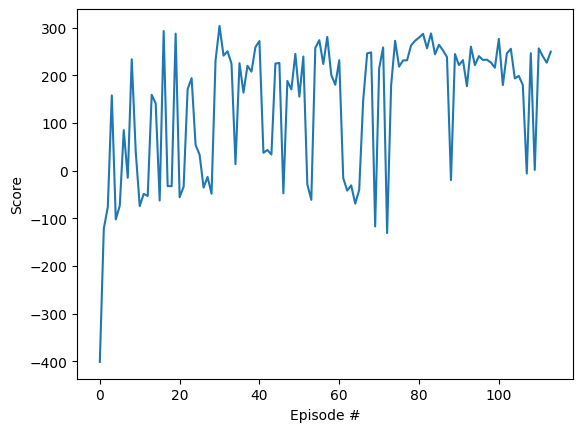

In [17]:
plot_scores(episode_scores)

## Deep Deterministic Policy Gradient (DDPG)

In [18]:
# Random noise generator: Taken from OpenAI baselines
class ActionNoise(object):
    def reset(self):
        pass

class OrnsteinUhlenbeckActionNoise(ActionNoise):
    def __init__(self, mu, sigma, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

In [19]:
std_dev = 0.2
ou_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(1), sigma=float(std_dev) * np.ones(1))

In [20]:
T = lambda x: torch.as_tensor(x, dtype=torch.float32)
Ti = lambda x: torch.as_tensor(x, dtype=torch.int64)

In [21]:
replay_memory = Replay_memory(env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE).initialize()

In [22]:
# Policy/Actor Network
class PolicyNet(nn.Module):

    def __init__(self, input_size, hidden_units, output_size, pmin, pmax):
        super(PolicyNet, self).__init__()
        self.pmin = pmin
        self.pmax = pmax
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, int(hidden_units/2)),
            nn.ReLU(),
            nn.Linear(int(hidden_units/2), output_size),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.model(x) * self.pmax
        torch.clip_(x, self.pmin, self.pmax)
        return x

    def __call__(self, x):
        out = self.forward(x)
        return out

In [23]:
#Critic Network
class DQN(nn.Module):

    def __init__(self, input_size, hidden_units):
        super(DQN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, int(hidden_units/2)),
            nn.ReLU(),
            nn.Linear(int(hidden_units/2), 1)
        )

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = self.model(x)
        return x

    def __call__(self, state, action):
        out = self.forward(state, action)
        return out

In [24]:
obs_size = env.observation_space.shape[0]
act_size = env.action_space.shape[0]
hiddenlayers = 256
output_minrange = env.action_space.low
output_maxrange = env.action_space.high

In [25]:
actor = PolicyNet(obs_size, hiddenlayers, act_size, T(output_minrange), T(output_maxrange))
actor_target = copy.deepcopy(actor)
critic = DQN(obs_size + act_size, hiddenlayers)
critic_target = copy.deepcopy(critic)

In [26]:
actor_optimizer  = optim.AdamW(actor.parameters(), lr=0.001)
critic_optimizer = optim.AdamW(critic.parameters(), lr=0.001)

In [27]:
def update():
        states, actions, rewards, dones, next_states = replay_memory.sample_batch()

        ou_noise.reset()
        # Critic loss
        Qvals = critic(states, actions)
        with torch.no_grad():
            actions_ = actor_target(next_states)
            Qvals_ = critic_target(next_states, actions_)
            Qvals_[dones] = 0.0
            target = rewards + GAMMA * Qvals_
        critic_loss = F.smooth_l1_loss(target, Qvals)

        # Actor Loss
        actor_loss = -critic(states, actor(states)).mean()

        # Update Networks
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()

        # Update Target Networks
        for target_param, param in zip(actor_target.parameters(), actor.parameters()):
            target_param.data.copy_(param.data * TAU + target_param.data * (1.0 - TAU))

        for target_param, param in zip(critic_target.parameters(), critic.parameters()):
            target_param.data.copy_(param.data * TAU + target_param.data * (1.0 - TAU))

In [28]:
returns = deque(maxlen=50)
episode_scores = []

for episode in count():
    state, _ = env.reset()
    episode_reward = 0
    done = False
    while not done:
        with torch.no_grad():
            action = actor(T(state)).numpy() + ou_noise()
        new_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        transition = Transition(state, action, reward, done, new_state)
        replay_memory.append(transition)
        update()
        state = new_state
        episode_reward += reward

    returns.append(episode_reward)
    episode_scores.append(episode_reward)
    score = np.mean(returns)
    if episode > 0 and episode % 100 == 0:
        print(f'Episode: {episode}  Return: {episode_reward}  Average Return: {score}')
    if score >= 195:
        print(f'Solved at episode: {episode} Avg Results: {score}')
        break

Episode: 100  Return: -22.00908657535427  Average Return: -6.059578399635337
Episode: 200  Return: 260.8302742575504  Average Return: 157.54137303647704
Solved at episode: 247 Avg Results: 198.34462079491345


In [39]:
env = rl.RenderFrame(env, "./video")
state, _ = env.reset()
done = False
while not done:
    with torch.no_grad():
        action = actor(T(state)).numpy() + ou_noise()
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        state = next_state
env.play()

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


In [37]:
def plot_scores(epsisode_scores):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  plt.plot(np.arange(len(episode_scores)), episode_scores)
  plt.ylabel('Score')
  plt.xlabel('Episode #')
  plt.show()

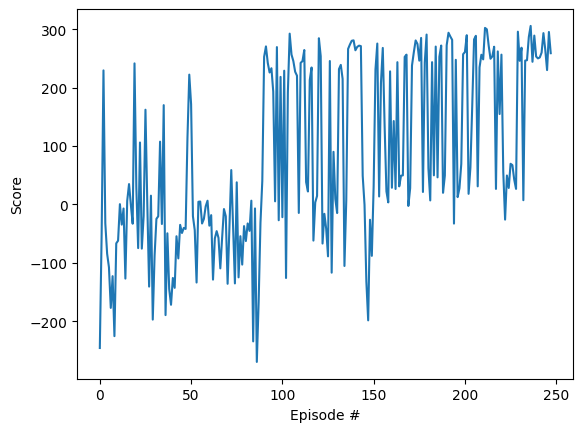

In [38]:
plot_scores(episode_scores)